In [55]:
import os
import pandas as pd
from anndata import read_h5ad
import scdrs
import scanpy as sc
import numpy as np
import sklearn.cluster as cluster
import statsmodels.regression.linear_model as lm
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))

In [4]:
DATA_PATH = "/project2/gilad/jpopp/ebQTL/data/"
RESULTS_PATH = "/project2/gilad/jpopp/ebQTL/results/"

In [5]:
adata = read_h5ad(os.path.join(DATA_PATH, "single_cell_objects/Lowpass.3seqbatches.merged.scvi_processed_and_scaled.h5ad"))
df_gs = pd.read_csv(os.path.join(DATA_PATH, "scDRS/gs_file/magma_10kb_1000.74_traits.gs"), sep="\t")

In [6]:
adata.X = adata.layers['lognorm']

In [7]:
scdrs.method.compute_stats(adata)

Too few genes for 20*20 bins, setting n_mean_bin=n_var_bin=17


## Schizophrenia scDRS

In [4]:
scz_scdrs = pd.read_csv(os.path.join(RESULTS_PATH, "scDRS/scz_results.csv"))
scz_scdrs

,Unnamed: 0,raw_score,norm_score,mc_pval,pval,nlog10_pval,zscore
0,1001_1_AAACCCACAGAAGTGC-1,0.188061,2.410146,0.007984,0.012518,1.902469,2.240850
1,1001_1_AAACGAAAGGTATTGA-1,0.235234,2.993897,0.003992,0.003144,2.502532,2.732384
2,1001_1_AAACGAAAGTAGATCA-1,0.074055,-0.907035,0.818363,0.815881,0.088373,-0.899777
3,1001_1_AAACGAATCTCAGGCG-1,0.082220,-2.883691,1.000000,0.999574,0.000185,-3.335274
4,1001_1_AAACGCTAGCAGGTCA-1,0.183837,0.686603,0.257485,0.239283,0.621088,0.708611
...,...,...,...,...,...,...,...
153864,1019_2_TTTGTTGCAACACACT-1,0.134571,-1.704780,0.958084,0.965131,0.015414,-1.813613
153865,1019_2_TTTGTTGCAAGTGATA-1,0.152482,1.241915,0.137725,0.111405,0.953096,1.219091
153866,1019_2_TTTGTTGCACTAGGCC-1,0.172261,1.743962,0.059880,0.047910,1.319575,1.665467
153867,1019_2_TTTGTTGCAGGGTCTC-1,0.188307,1.261864,0.103792,0.108034,0.966438,1.237049


In [7]:
adata.obs['scz_norm_score'] = scz_scdrs['norm_score'].to_numpy()
adata.obs['scz_nlog10_pval'] = scz_scdrs['nlog10_pval'].to_numpy()

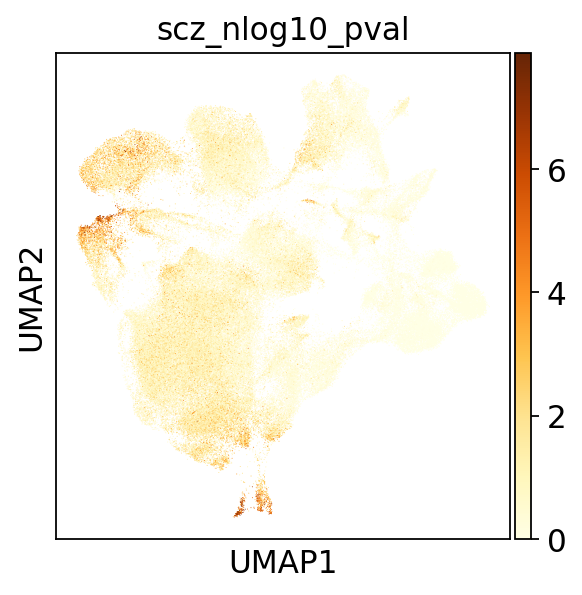

In [89]:
sc.pl.umap(adata, color=['scz_nlog10_pval'], color_map="YlOrBr")

## IBD scDRS

In [ ]:
ibd_scdrs = pd.read_csv(os.path.join(RESULTS_PATH, "scDRS/ibd_results.csv"))
adata.obs['ibd_norm_score'] = ibd_scdrs['norm_score'].to_numpy()
adata.obs['ibd_nlog10_pval'] = ibd_scdrs['nlog10_pval'].to_numpy()

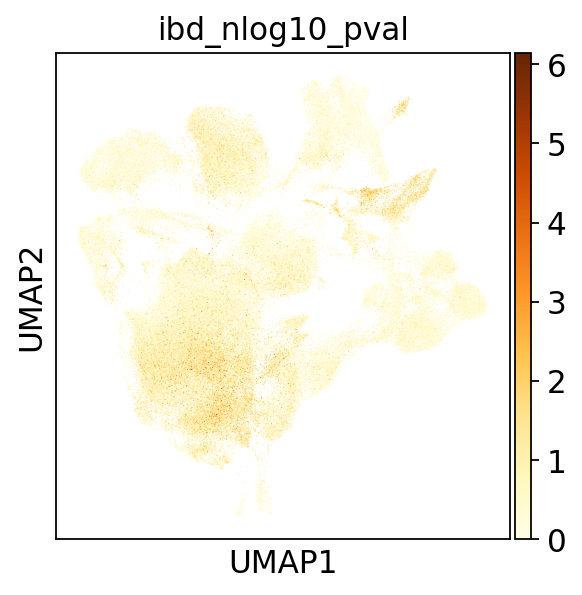

In [90]:
sc.pl.umap(adata, color=['ibd_nlog10_pval'], color_map="YlOrBr")

## HT scDRS

In [14]:
ht_scdrs = pd.read_csv(os.path.join(RESULTS_PATH, "scDRS/htn_results.csv"))
adata.obs['ht_norm_score'] = ht_scdrs['norm_score'].to_numpy()
adata.obs['ht_nlog10_pval'] = ht_scdrs['nlog10_pval'].to_numpy()

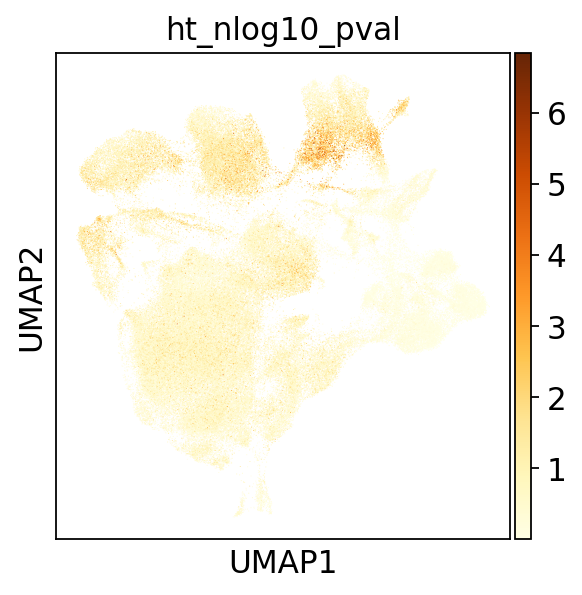

In [91]:
sc.pl.umap(adata, color=['ht_nlog10_pval'], color_map="YlOrBr")

## Zooming in on the mesoderm lineage

It looks like we're primarily picking up on terminal cell types, but are there a subset of genes in the gene sets that are most active at early or intermediate stages? Maybe we could stratify genes by group. To explore this, I'm going to hone in on the hypertension gene set and relevant cell types

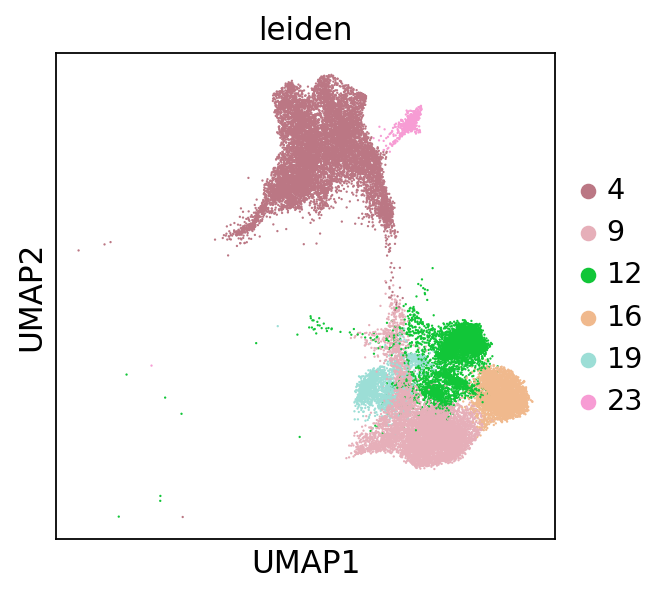

In [20]:
meso_cells = [c in ['4', '9', '12', '16', '19', '23'] for c in adata.obs['leiden']]
sc.pl.umap(adata[meso_cells], color='leiden')

In [208]:
adata_mes = adata[meso_cells].raw.to_adata()
adata_mes

AnnData object with n_obs × n_vars = 27888 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'DROPLET.TYPE', 'SNG.POSTERIOR', 'NUM.SNPS', 'individual', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'FREE.TYPE', 'FREE.SNG.POSTERIOR', 'FREE.NUM.SNPS', 'free.individual', 'ALL.TYPE', 'ALL.SNG.POSTERIOR', 'ALL.NUM.SNPS', 'all.individual', 'c.date', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',

In [209]:
sc.pp.filter_genes(adata_mes, min_cells=30)
sc.pp.filter_cells(adata_mes, min_genes=1000)
adata_mes

AnnData object with n_obs × n_vars = 27888 × 25895
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'DROPLET.TYPE', 'SNG.POSTERIOR', 'NUM.SNPS', 'individual', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'FREE.TYPE', 'FREE.SNG.POSTERIOR', 'FREE.NUM.SNPS', 'free.individual', 'ALL.TYPE', 'ALL.SNG.POSTERIOR', 'ALL.NUM.SNPS', 'all.individual', 'c.date', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',

In [210]:
adata_mes.layers['counts'] = adata_mes.X.copy()
sc.pp.normalize_total(adata_mes)
sc.pp.log1p(adata_mes)
adata_mes.layers['logcounts'] = adata_mes.X.copy()

In [211]:
sc.pp.highly_variable_genes(adata_mes, layer='counts', flavor='seurat_v3', n_top_genes=3000, subset=True)

/home/jpopp/.conda/envs/singlecell/lib/python3.8/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


In [232]:
adata_mes.X = adata_mes.layers['logcounts']

In [233]:
sc.pp.scale(adata_mes, max_value=5)
adata_mes.layers['scale'] = adata_mes.X.copy()

In [234]:
sc.pp.pca(adata_mes)
sc.pp.neighbors(adata_mes)

In [235]:
sc.tl.paga(adata_mes, groups='leiden')

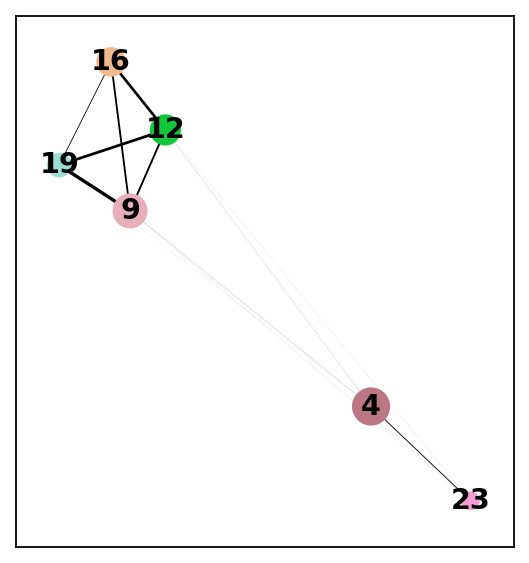

In [236]:
sc.pl.paga(adata_mes, threshold=0)

In [237]:
sc.tl.diffmap(adata_mes)
adata_mes.uns['iroot'] = np.argmax(adata_mes.X[:, list(adata.var_names).index("POU5F1")])
sc.tl.dpt(adata_mes)

In [238]:
sc.tl.draw_graph(adata_mes, init_pos='paga')

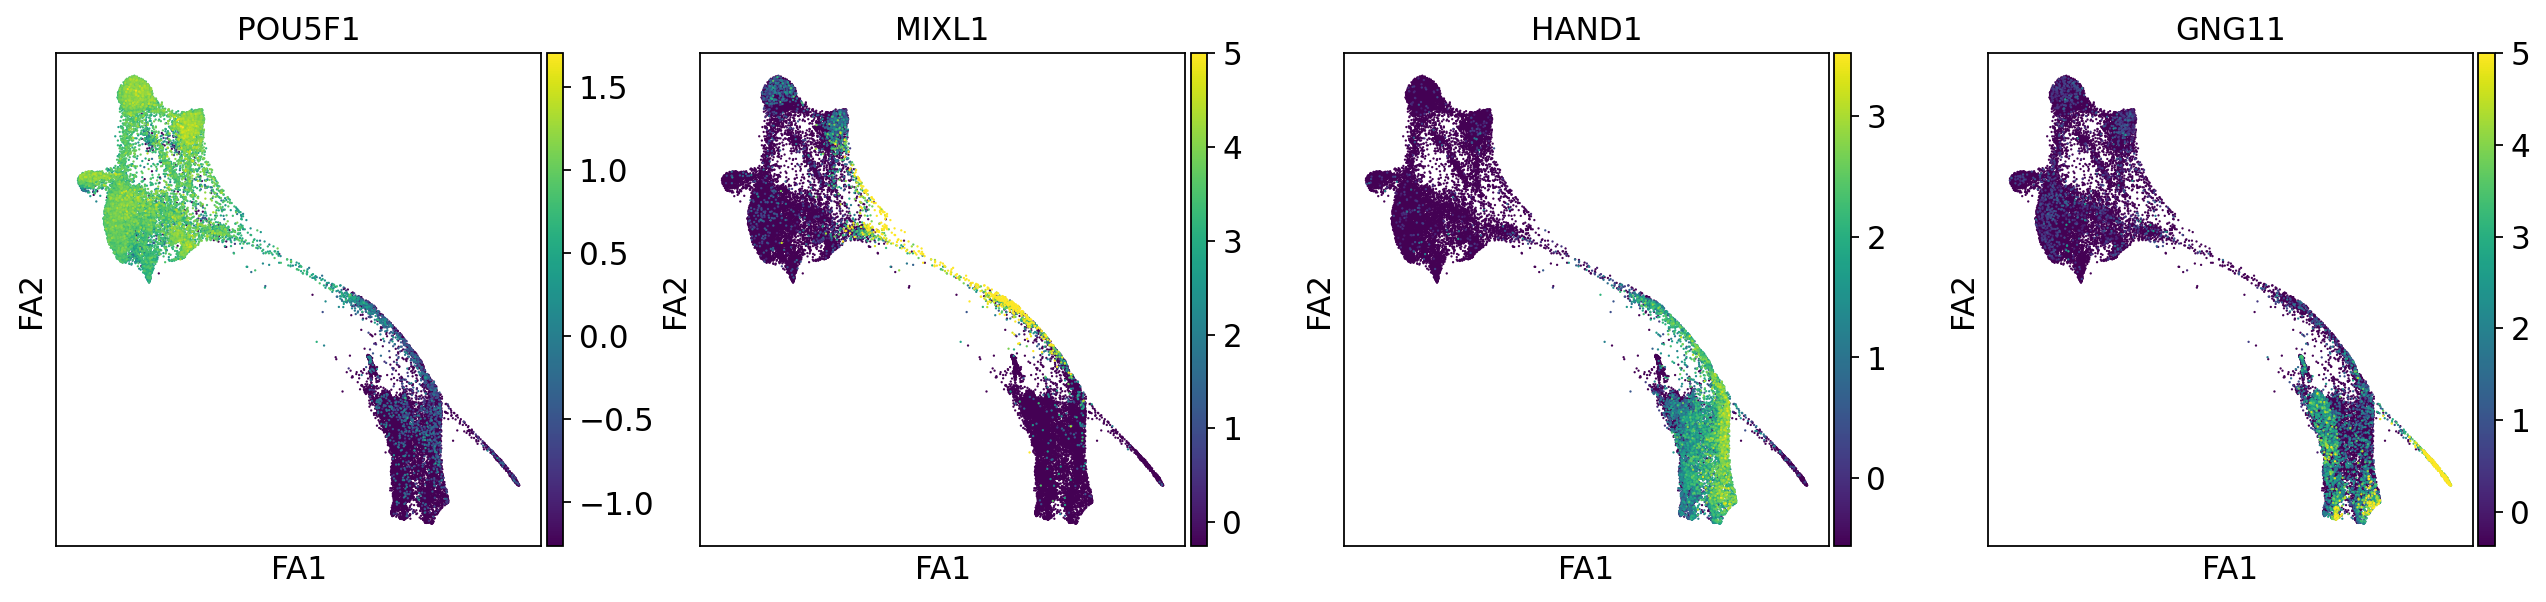

In [239]:
sc.pl.draw_graph(adata_mes, color=['POU5F1', 'MIXL1', 'HAND1', 'GNG11'])

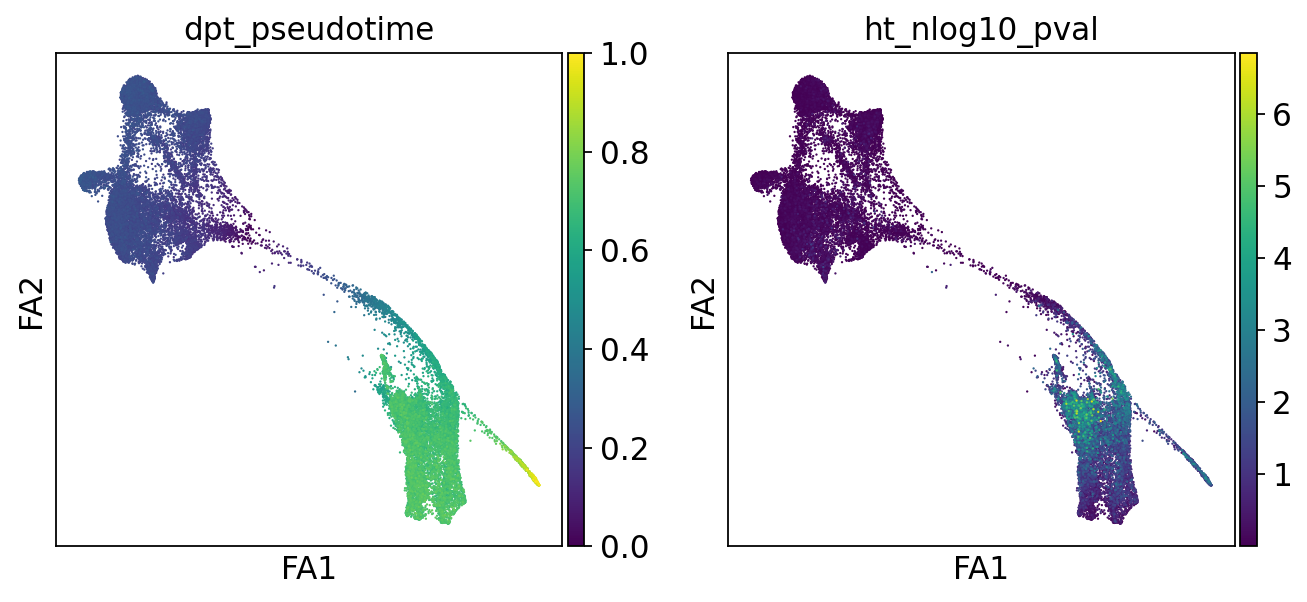

In [240]:
sc.pl.draw_graph(adata_mes, color=['dpt_pseudotime', 'ht_nlog10_pval'])

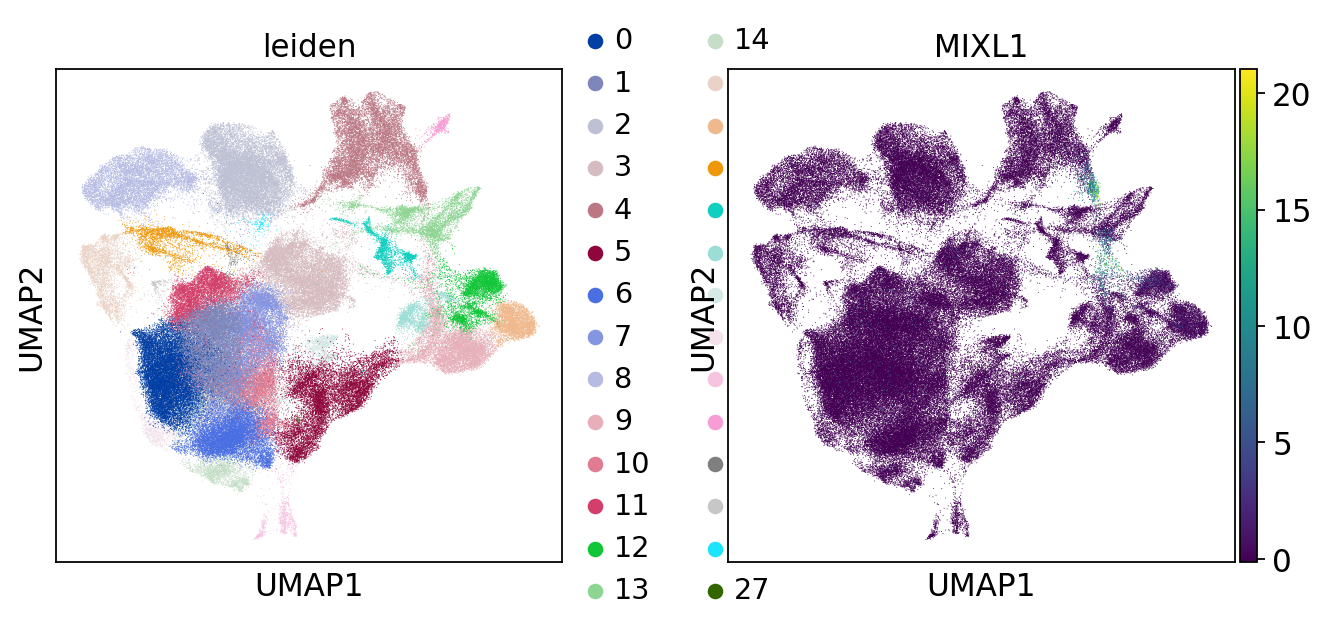

In [264]:
sc.pl.umap(adata, color=['leiden', 'MIXL1'], use_raw=False)

In [241]:
adata_mes.write_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/Lowpass.3seqbatches.merged.meso_lineage.h5ad")

## Hypertension gene clusters

In [2]:
adata_mes = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/Lowpass.3seqbatches.merged.meso_lineage.h5ad")

There are 1000 genes used for scDRS, but 112 of them overlap with our highly variable features - let's cluster those first

In [6]:
htn_gene_list=df_gs[df_gs['TRAIT']=='UKB_460K.disease_HYPERTENSION_DIAGNOSED']['GENESET'].values[0].split(",")
len(htn_gene_list)

1000

In [7]:
len(set(htn_gene_list) & set(adata_mes.var_names))

120

In [8]:
de_disease_genes = list(set(htn_gene_list) & set(adata_mes.var_names))
de_disease_genes

['ZEB2',
 'ZNF385D',
 'CDC20',
 'HOXB3',
 'PRDM6',
 'SLC39A8',
 'LEF1',
 'MAST4',
 'SGIP1',
 'PEG10',
 'ZNF536',
 'CACNB2',
 'CACNA1D',
 'ANKK1',
 'ZAP70',
 'CYB5D1',
 'IGF2',
 'PKHD1',
 'CHMP4C',
 'FCN3',
 'EDNRA',
 'CUX2',
 'CALN1',
 'SCN9A',
 'NPPA',
 'PIEZO2',
 'PMEL',
 'PPM1E',
 'MBNL2',
 'CACNA1C',
 'MMP16',
 'PAX2',
 'UNC5C',
 'HOXC10',
 'PREX1',
 'RSPO3',
 'LYZ',
 'SLC4A10',
 'TMEM88',
 'NGF',
 'ZNF641',
 'BMPR1B',
 'SOX5',
 'WT1',
 'AUTS2',
 'SHROOM3',
 'SOX6',
 'NRXN1',
 'ADM',
 'SMOC1',
 'ARHGEF28',
 'SLC35F3',
 'SETBP1',
 'PCP4',
 'CEMIP',
 'TBX2',
 'CALB1',
 'EBF2',
 'UGT2B7',
 'LITAF',
 'LHFPL2',
 'NFATC2',
 'HOXB6',
 'JARID2',
 'BICC1',
 'C11orf88',
 'MPO',
 'MECOM',
 'SVEP1',
 'TIE1',
 'ABO',
 'ROBO1',
 'FBN2',
 'TFAP2B',
 'PDE8B',
 'HOXA10',
 'SULT6B1',
 'WNT3A',
 'TENM2',
 'HOXB5',
 'ATP2B1',
 'CAST',
 'ASB15',
 'DNM3',
 'CALCRL',
 'SLC39A12',
 'AGBL2',
 'MEIS1',
 'PDE1A',
 'NPPB',
 'PDE10A',
 'TFPI',
 'FOXP2',
 'PODXL',
 'MYL4',
 'SLC17A6',
 'LRP1B',
 'PLEKHG1',
 'TU

In [9]:
exp = np.transpose(np.matrix(adata_mes[:, de_disease_genes].layers['scale']))

In [10]:
kmeans = cluster.KMeans(n_clusters=3).fit(exp)

In [11]:
clusts = {str(i): list(np.array(de_disease_genes)[np.where(kmeans.labels_==i)[0]]) for i in range(3)}

In [12]:
adata_mes.obs['pseudotime_quantile'] = pd.qcut(adata_mes.obs['dpt_pseudotime'], 10)

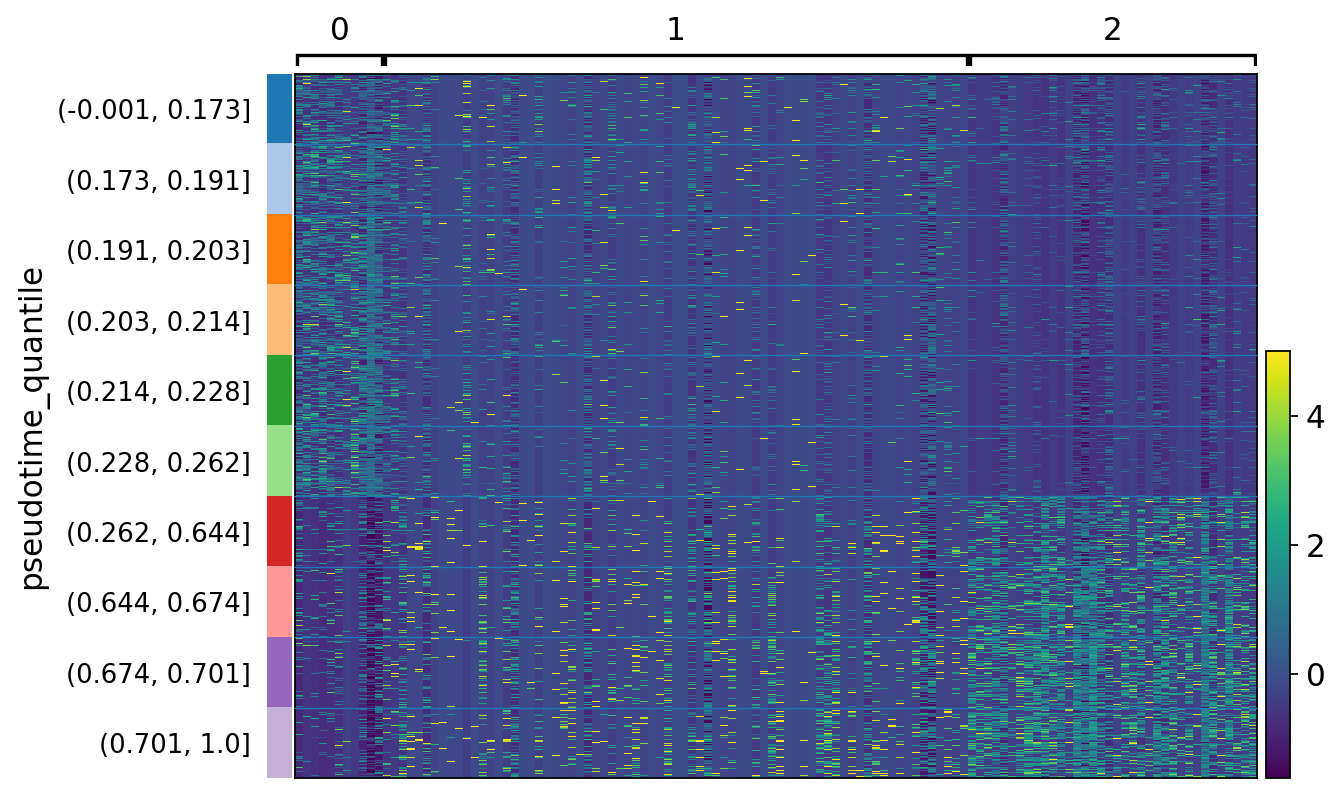

In [13]:
sc.pl.heatmap(adata_mes, clusts, groupby="pseudotime_quantile", num_categories=10, 
              use_raw=False, layer="scale")

In [14]:
ht_early_genes = list(np.array(de_disease_genes)[np.where(kmeans.labels_==0)[0]])
ht_late_genes = list(np.array(de_disease_genes)[np.where(kmeans.labels_==1)[0]])

In [17]:
sc.tl.score_genes(adata_mes, ht_early_genes, score_name='ht_early')
sc.tl.score_genes(adata_mes, ht_late_genes, score_name='ht_late')

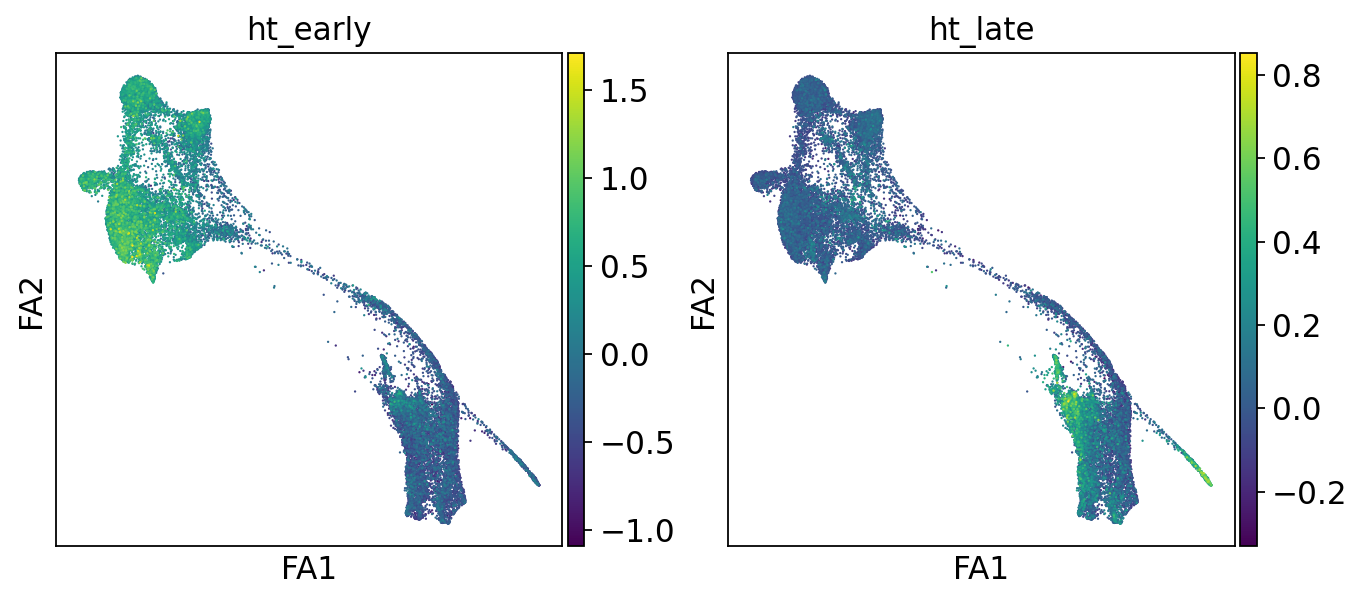

In [18]:
sc.pl.draw_graph(adata_mes, color=['ht_early', 'ht_late'])

Do these scores vary between individuals?

/home/jpopp/.conda/envs/singlecell/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jpopp/.conda/envs/singlecell/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


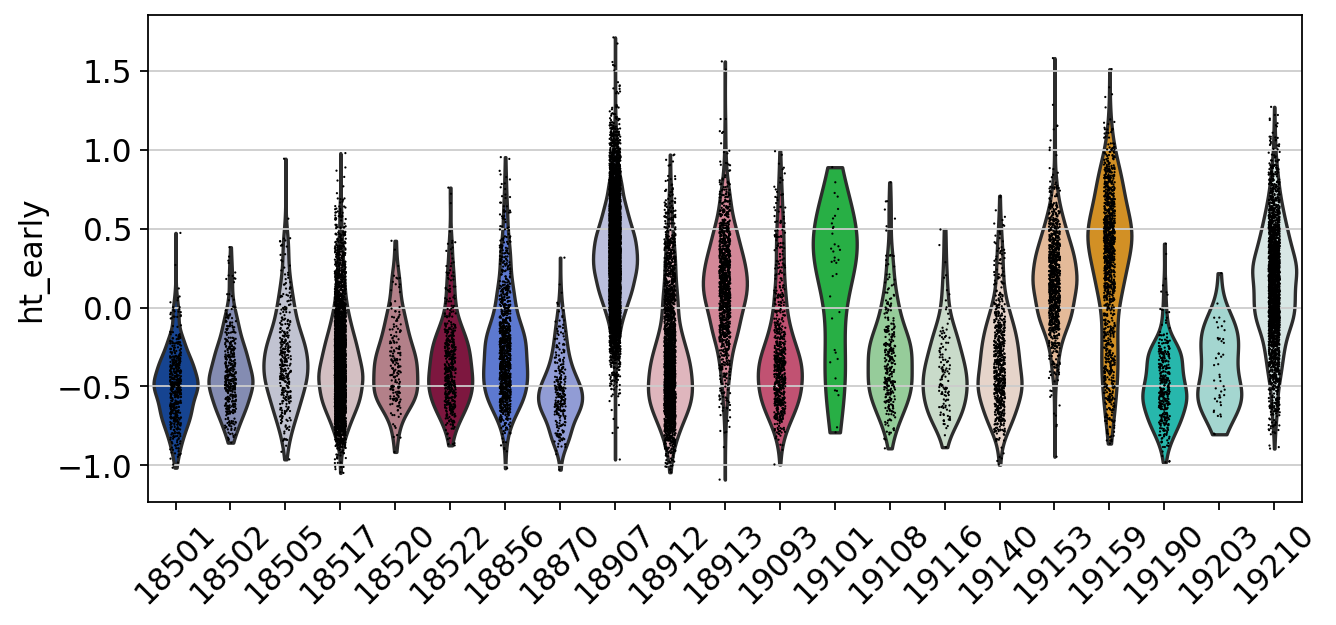

In [128]:
sc.set_figure_params(figsize=(8, 4))
sc.pl.violin(adata_mes, 'ht_early', groupby='individual', rotation=45)

/home/jpopp/.conda/envs/singlecell/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jpopp/.conda/envs/singlecell/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


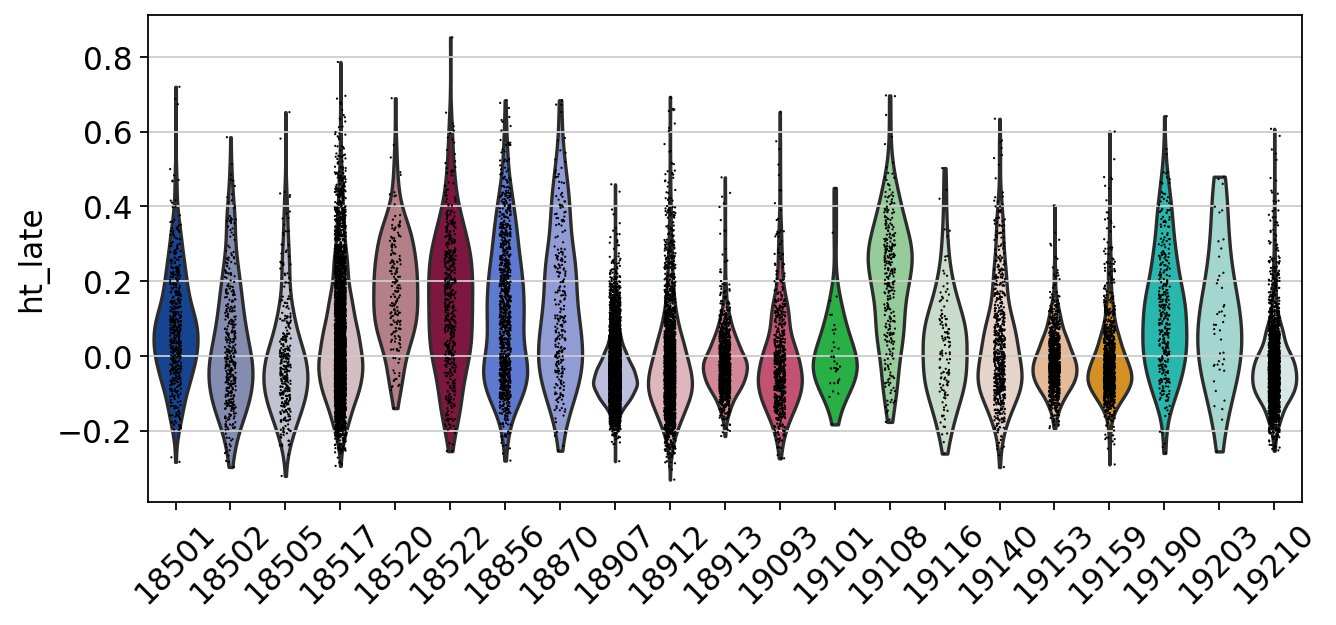

In [28]:
sc.pl.violin(adata_mes, 'ht_late', groupby='individual', rotation=45)

/home/jpopp/.conda/envs/singlecell/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jpopp/.conda/envs/singlecell/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


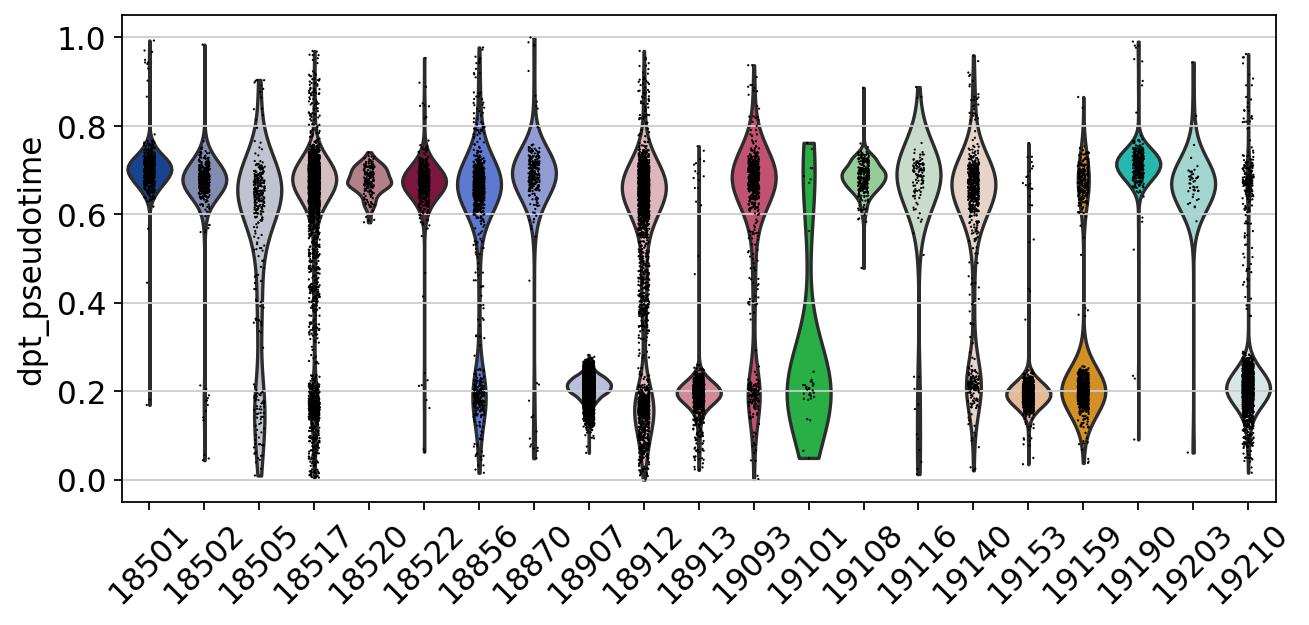

In [129]:
sc.pl.violin(adata_mes, 'dpt_pseudotime', groupby='individual', rotation=45)

How much do the scores vary between individuals before and after controlling for pseudotime?

In [80]:
lm_df = adata_mes.obs[['ht_early', 'ht_late', 'individual', 'dpt_pseudotime']]
lm_df['intercept'] = np.ones(len(lm_df))

/tmp/jobs/14130815/ipykernel_8366/1814583980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lm_df['intercept'] = np.ones(len(lm_df))


In [130]:
design_nonpt = np.array(lm_df[['intercept', 'individual']]).astype(float)
design_pt = np.array(lm_df[['intercept', 'individual', 'dpt_pseudotime']]).astype(float)

ht_early = np.array(lm_df['ht_early']).astype(float)
ht_late = np.array(lm_df['ht_late']).astype(float)

In [131]:
ht_early_nonpt_model = lm.OLS(ht_early, design_nonpt)
ht_early_nonpt_results = ht_early_nonpt_model.fit()
ht_early_nonpt_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     3620.
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:24:45   Log-Likelihood:                -15387.
No. Observations:               27888   AIC:                         3.078e+04
Df Residuals:                   27886   BIC:                         3.079e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.6861      0.211    -60.159      0.000     -13.099     -12.273
x1             0.0007   1.12e-05     60.164      0.000       0.001       0.001
==============================================================================
Omnibus:                      378.400   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.681
Skew:                           0.017   Prob(JB):                     9.86e-50
Kurtosis:                       2.561   Cond. No.                     1.58e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [132]:
ht_early_pt_model = lm.OLS(ht_early, design_pt)
ht_early_pt_results = ht_early_pt_model.fit()
ht_early_pt_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                 1.661e+04
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:25:18   Log-Likelihood:                -6150.3
No. Observations:               27888   AIC:                         1.231e+04
Df Residuals:                   27885   BIC:                         1.233e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5156      0.169     -3.050      0.002      -0.847      -0.184
x1          5.522e-05   8.88e-06      6.221      0.000    3.78e-05    7.26e-05
x2            -1.3765      0.009   -161.854      0.000      -1.393      -1.360
==============================================================================
Omnibus:                      270.488   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              402.061
Skew:                           0.103   Prob(JB):                     4.94e-88
Kurtosis:                       3.551   Cond. No.                     1.77e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [126]:
ht_late_nonpt_model = lm.OLS(ht_late, design_nonpt)
ht_late_nonpt_results = ht_late_nonpt_model.fit()
ht_late_nonpt_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     5229.
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:20:48   Log-Likelihood:                 18960.
No. Observations:               27888   AIC:                        -3.792e+04
Df Residuals:                   27886   BIC:                        -3.790e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0863      0.001    -61.519      0.000      -0.089      -0.084
x1             0.2257      0.003     72.308      0.000       0.220       0.232
==============================================================================
Omnibus:                     3494.507   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7453.584
Skew:                           0.771   Prob(JB):                         0.00
Kurtosis:                       5.009   Cond. No.                         4.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [133]:
ht_early_genes

['CDC20',
 'CUX2',
 'CALN1',
 'PMEL',
 'PPM1E',
 'NRXN1',
 'ADM',
 'CALB1',
 'LITAF',
 'JARID2',
 'PODXL']

In [146]:
ht_early_ind = [list(adata_mes.var_names).index(g) for g in ht_early_genes]
early_exp = pd.DataFrame(adata_mes.X[:, ht_early_ind])
early_exp.columns = ht_early_genes
early_exp.to_csv("../data/meso_exp_early_ht_genes.tsv", sep="\t")

In [147]:
ht_late_ind = [list(adata_mes.var_names).index(g) for g in ht_late_genes]
late_exp = pd.DataFrame(adata_mes.X[:, ht_late_ind])
late_exp.columns = ht_late_genes
late_exp.to_csv("../data/meso_exp_late_ht_genes.tsv", sep="\t")

In [151]:
meta = adata_mes.obs[['individual', 'dpt_pseudotime']]
meta.to_csv("../data/meso_meta.tsv", sep="\t")